In [1]:
#!pip install torch
#!pip install torchvision
#!pip install imgaug
import torch      #pytorch
import torch.nn as nn     #pytorch network
from torch.utils.data import Dataset, DataLoader      #pytorch dataset
from torch.utils.tensorboard import SummaryWriter     #tensorboard
import torchvision      #torchvision
import torch.optim as optim     #pytorch optimizer
import numpy as np      #numpy
import matplotlib.pyplot as plt     #matplotlib(이미지 표시를 위해 필요)
from collections import OrderedDict     #python라이브러리 (라벨 dictionary를 만들 때 필요)
import os     #os
import xml.etree.ElementTree as Et      #Pascal xml을 읽어올 때 필요
from xml.etree.ElementTree import Element, ElementTree
import cv2      #opencv (box 그리기를 할 때 필요)
from PIL import Image     #PILLOW (이미지 읽기)
import time     #time
import imgaug as ia     #imgaug
from imgaug import augmenters as iaa
from torchvision import transforms      #torchvision transform
import pandas as pd
#GPU연결
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cpu


In [2]:
from utils import CLASS_NAME_TO_ID, visualize, CLASS_ID_TO_NAME, visualized, visualizes

In [3]:
data_dir = '../image/image/' # 안에 image, train, val, df.csv가 있음 데이터가 나눠지면 수정예정
data_dir_ = '../image/'
data_df = pd.read_csv('modi_xml0.5.csv')
# data_df = pd.read_csv('all_data_drop_na.csv')

In [4]:
data_df['occupied'].value_counts()

0    358742
1    335386
Name: occupied, dtype: int64

In [5]:
data_df[data_df['filename'].str.contains('2012-09-11_15_16_58')]

,Unnamed: 0,filename,center_x,center_y,width,height,angle,occupied,x_max,x_min,y_max,y_min
0,0,2012-09-11_15_16_58_1,300,207,55,32,-74,1,162.0,139.0,115.0,92.5
1,1,2012-09-11_15_16_58_2,332,209,56,33,-77,0,177.5,155.0,116.5,92.5
2,2,2012-09-11_15_16_58_3,366,208,52,32,-77,1,194.0,172.5,116.5,92.5
3,3,2012-09-11_15_16_58_4,398,207,54,36,-79,0,210.5,187.5,116.0,92.0
4,4,2012-09-11_15_16_58_5,430,210,50,31,-75,1,226.0,204.5,116.0,93.5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2012-09-11_15_16_58_96,441,530,67,53,-77,0,237.5,204.0,280.5,252.0
96,96,2012-09-11_15_16_58_97,494,537,70,54,-79,0,263.5,230.5,283.5,253.5
97,97,2012-09-11_15_16_58_98,549,534,64,55,-82,0,290.5,259.0,281.5,252.0
98,98,2012-09-11_15_16_58_99,602,536,64,47,-85,0,314.5,288.0,283.5,252.5


In [6]:
# listdir를 이용하여 images 디렉토리의 .jpg 파일을 읽어와서 0번 화면에 plt.imshow로 출력
index = 0
# images 폴더에 있는 모든 jpg 파일을 읽어옴
image_files = [fn for fn in os.listdir(data_dir) if fn.endswith('jpg')] 
# 모든 jpg 파일 중 첫번째 파일의 이름을 저장
image_file = image_files[index]
image_file

'2012-09-11_15_16_58.jpg'

In [7]:
image_path = os.path.join(data_dir, image_file) # 모든 jpg 파일 중 첫번째 파일의 path를 저장

In [8]:
image_path

'../image/image/2012-09-11_15_16_58.jpg'

In [9]:
image = cv2.imread(image_path) # 첫번째 파일(이미지)를 읽어옴
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2로 읽었으니 RGB로 바꿔줌

In [10]:
print(image.shape) # 세로 170, 가로 256, 색상 3 채널

(720, 1280, 3)


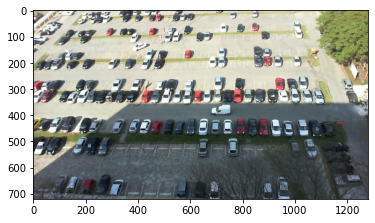

In [11]:
plt.imshow(image)

In [12]:
image_id = image_file.split('.')[0] # 첫번째 파일 이름에서 .jpg를 제외함 (이미지 고유 아이디)
image_id

'2012-09-11_15_16_58'

In [13]:
meta_data = data_df[data_df['filename'].str.contains(image_id)] 

In [14]:
meta_data

,Unnamed: 0,filename,center_x,center_y,width,height,angle,occupied,x_max,x_min,y_max,y_min
0,0,2012-09-11_15_16_58_1,300,207,55,32,-74,1,162.0,139.0,115.0,92.5
1,1,2012-09-11_15_16_58_2,332,209,56,33,-77,0,177.5,155.0,116.5,92.5
2,2,2012-09-11_15_16_58_3,366,208,52,32,-77,1,194.0,172.5,116.5,92.5
3,3,2012-09-11_15_16_58_4,398,207,54,36,-79,0,210.5,187.5,116.0,92.0
4,4,2012-09-11_15_16_58_5,430,210,50,31,-75,1,226.0,204.5,116.0,93.5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2012-09-11_15_16_58_96,441,530,67,53,-77,0,237.5,204.0,280.5,252.0
96,96,2012-09-11_15_16_58_97,494,537,70,54,-79,0,263.5,230.5,283.5,253.5
97,97,2012-09-11_15_16_58_98,549,534,64,55,-82,0,290.5,259.0,281.5,252.0
98,98,2012-09-11_15_16_58_99,602,536,64,47,-85,0,314.5,288.0,283.5,252.5


In [15]:
cate_names = meta_data['occupied'].values # 메타 데이터의 라벨(버스, 트럭)을 가져옴

In [16]:
cate_names

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [17]:
meta_data['occupied'].value_counts()

1    67
0    33
Name: occupied, dtype: int64

In [18]:
bboxes = [meta_data[['center_x', 'center_y', 'width', 'height']].values ]
bboxes

[array([[ 300,  207,   55,   32],
        [ 332,  209,   56,   33],
        [ 366,  208,   52,   32],
        [ 398,  207,   54,   36],
        [ 430,  210,   50,   31],
        [ 482,  208,   49,   32],
        [ 517,  208,   43,   30],
        [ 550,  209,   48,   28],
        [ 582,  207,   47,   31],
        [ 615,  208,   44,   32],
        [ 649,  206,   37,   32],
        [ 683,  206,   39,   34],
        [ 718,  203,   32,   38],
        [ 753,  203,   43,   36],
        [ 791,  203,   32,   43],
        [ 824,  202,   32,   40],
        [ 862,  201,   34,   39],
        [ 898,  200,   35,   36],
        [ 936,  202,   38,   40],
        [ 974,  200,   32,   46],
        [1007,  199,   34,   43],
        [1045,  199,   38,   48],
        [ 253,  287,   57,   34],
        [ 285,  290,   57,   33],
        [ 319,  286,   49,   35],
        [ 360,  290,   52,   38],
        [ 400,  288,   46,   36],
        [ 448,  287,   41,   39],
        [ 480,  288,   44,   40],
        [ 524,

In [19]:
CLASS_NAME_TO_ID

{'empty': 0.0, 'occupied': 1.0}

In [20]:
img_H, img_W, _ = image.shape # 첫번째 사진의 세로와 가로 길이를 저장함

class_ids = [[cate_name] for cate_name in cate_names]
class_ids = [tuple(i) for i in class_ids]

In [21]:
print(img_H)
print(img_W)

720
1280


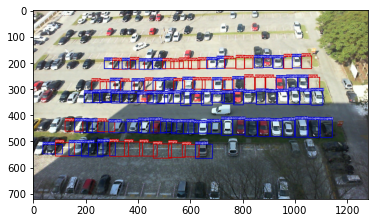

In [22]:
canvas = visualize(image, bboxes, class_ids) # 바운딩 박스를 그려줌
plt.figure(figsize = (6, 6))
plt.imshow(canvas)
plt.show()

In [23]:
class Detection_dataset() :
    def __init__(self, data_dir, phase, transformer = None) :
        self.data_dir = data_dir
        self.phase = phase
        self.transformer = transformer
        self.data_df = pd.read_csv('modi_xml0.5.csv')
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]

    def __len__(self) :
        return len(self.image_files)

    def __getitem__(self, index) :
        filename, image = self.get_image(index) # index의 이미지 파일 제목, 이미지
        bboxes, class_ids = self.get_label(filename) # ['XMin', 'YMin', 'XMax', 'YMax'], class_ids

        if self.transformer :
            image = self.transformer(image)

        target = {}
        target['boxes'] = torch.Tensor(bboxes).float()
        target['labels'] = torch.Tensor(class_ids).long()
        return image, target, filename # target에는 박스 좌표와 라벨이 들어가 있음

    def get_image(self, index) :
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename) :
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['filename'].str.contains(image_id)]
        class_ids = meta_data['occupied'].values
        bboxes = meta_data[['x_min', 'y_min', 'x_max', 'y_max']].values
#         bboxes = [meta_data[['center_x', 'center_y', 'width', 'height']].values ]
        return bboxes, class_ids # 하나의 사진 안에 들어있는 바운딩 박스(들)의 좌표와 라벨(1, 0)

In [24]:
dataset = Detection_dataset(data_dir = data_dir_, phase = 'train', transformer=None)

In [25]:
len(dataset)

9122

In [26]:
image, target, filename = dataset[0]

In [27]:
image.shape

(720, 1280, 3)

In [28]:
filename

'2012-09-11_15_36_32.jpg'

In [29]:
boxes = target['boxes'].numpy()
boxes

array([[139. ,  92.5, 162. , 115. ],
       [155. ,  92.5, 177.5, 116.5],
       [172.5,  92.5, 194. , 116.5],
       [187.5,  92. , 210.5, 116. ],
       [204.5,  93.5, 226. , 116. ],
       [230.5,  92. , 251.5, 115. ],
       [250. ,  93. , 267.5, 114.5],
       [267. ,  93. , 283.5, 116. ],
       [282.5,  92. , 299.5, 115. ],
       [299. ,  93. , 317. , 115. ],
       [316. ,  93.5, 332. , 113. ],
       [332.5,  93. , 349.5, 113.5],
       [351. ,  92. , 367. , 111. ],
       [367.5,  91. , 386. , 112.5],
       [387.5,  91. , 403.5, 112.5],
       [403.5,  91.5, 421. , 111. ],
       [422. ,  91.5, 439.5, 111. ],
       [440. ,  91. , 457.5, 109.5],
       [458.5,  91. , 478. , 111. ],
       [478. ,  88.5, 496. , 111. ],
       [496.5,  90. , 511. , 109.5],
       [511. ,  87.5, 534. , 110. ],
       [113. , 133.5, 140. , 155. ],
       [129.5, 132.5, 156. , 155. ],
       [147.5, 133. , 172. , 156. ],
       [167.5, 134. , 193. , 155. ],
       [188.5, 134. , 212. , 156. ],
 

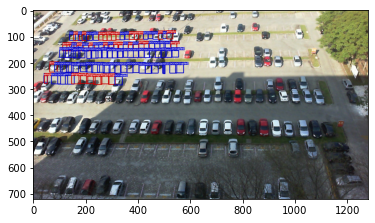

In [30]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy() 

n_obj = boxes.shape[0] # 1행
bboxes = np.zeros(shape = (n_obj, 4), dtype = np.float32) 
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2 
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]  

canvas = visualized(image, bboxes, class_ids)

plt.figure(figsize = (6,6))
plt.imshow(canvas)
plt.show()

In [31]:
# IMAGE_SIZE = 448 

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (360, 640)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [32]:
# data_dir = './DRIVING-DATASET/Detection/'
transformed_dataset = Detection_dataset(data_dir=data_dir_, phase = 'train', transformer=transformer)

In [33]:
from torchvision.utils import make_grid

In [34]:
index = 1
image, target, filename = transformed_dataset[index]

In [35]:
image.shape

torch.Size([3, 360, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


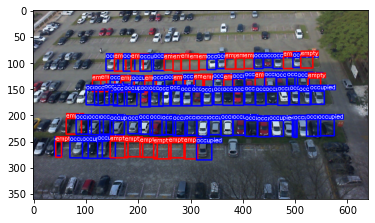

In [36]:
# np_image = make_grid(image, normalize = True).cpu().permute(1, 2, 0).numpy()
np_image = make_grid(image, normalize = True).cpu().permute(1, 2, 0).numpy()

boxes = target['boxes'].numpy() 
class_ids = target['labels'].numpy() 

n_obj = boxes.shape[0] 
bboxes = np.zeros(shape = (n_obj, 4), dtype = np.float32) 
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2 
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualized(np_image, bboxes, class_ids)

plt.figure(figsize = (6, 6))
plt.imshow(canvas)
plt.show() 

In [37]:
from torch.utils.data import DataLoader

In [38]:
def collate_fn(batch) :
    image_list = []
    target_list = []
    filename_list = []
    
    for a, b, c in batch :
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)
    
    return image_list, target_list, filename_list

In [39]:
# data_dir = './DRIVING-DATASET/Detection'
BATCH_SIZE = 6

trainset = Detection_dataset(data_dir = data_dir_, phase = 'train', transformer = transformer)
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn)

In [40]:
for index, batch in enumerate(trainloader) :
    images = batch[0]
    targets = batch[1]
    filnames = batch[2]
    
    if index == 0 :
        break

In [41]:
def build_dataloader(data_dir, batch_size = 4) :
    dataloaders = {}
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = (360, 640)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = Detection_dataset(data_dir, 'train', transformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
    
    val_dataset = Detection_dataset(data_dir, 'test', transformer)
    dataloaders['val'] = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
    
    return dataloaders

In [42]:
dloaders = build_dataloader(data_dir_, batch_size = 4)

for phase in ['train', 'val'] :
    for index, batch in enumerate(dloaders[phase]) :
        images = batch[0]
        targets = batch[1]
        filnames = batch[2]
        print(len(filnames))
        if index == 0 :
            break

4
4


# 블로그에서 복사해온 모델링 코드 부분

```
backbone = torchvision.models.vgg16(pretrained=True).features[:-1]
backbone_out = 512
backbone.out_channels = backbone_out

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))

resolution = 7
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,21) #21개 class

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 600, max_size = 1000,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,
                   rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,
                   rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.05, box_nms_thresh=0.7,box_detections_per_img=300,
                   box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 )
#roi head 있으면 num_class = None으로 함

for param in model.rpn.parameters():
  torch.nn.init.normal_(param,mean = 0.0, std=0.01)

for name, param in model.roi_heads.named_parameters():
  if "bbox_pred" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.001)
  elif "weight" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.01)
  if "bias" in name:
    torch.nn.init.zeros_(param)
```

# 코드에 관한 설명

### 모델을 만드는 코드입니다. backbone으로 VGG16을 사용하며 마지막 max pooling층은 제거해 줍니다. Faster RCNN을 사용하기 위해서는 fully connected layer를 만들기 위해 최종 backbone output채널이 512임을 알려주어야 합니다.
### 이후 anchor generator, roi pooler, box head, box predictor를 각각 만들어 줍니다.
### box head는 Fast RCNN에서 처음 두 FC layer에 해당하는 층이고 box predictor는 예측을 하는 FC layer입니다.

### 모델은 torchvision.models.detection에 있는 FasterRCNN을 사용합니다. 입력해야 하는 값을 point 에 있는 값들을 참고하여 입력하면 됩니다. default로 None인 항목 중 point에 없는 항목은 그대로 두어도 논문과 같거나 큰 영향이 없는 값들입니다.
### 마지막으로 weight와 bias를 초기화합니다. 참고로 box_score_thresh와 box_nms_thresh는 예측때 필요한 값이므로 일단 임의의 값을 입력합니다.

In [43]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # 모델의 헤더를 수정할 수 있게 해주는 클래스

In [44]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

C:\Users\lhj02\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\lhj02\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [46]:
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [47]:
def build_model(num_classes) :
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [48]:
NUM_CLASSES = 2
model = build_model(num_classes = NUM_CLASSES)

In [49]:
phase = 'train'
model.train() # Sets the module in training mode.

for index, batch in enumerate(dloaders[phase]) :
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    images = list(image for image in images)
    targets = [{k : v for k, v in t.items()} for t in targets]
    
    for i in range(len(targets)):
        targets[i]['boxes'] = targets[i]['boxes'].squeeze(0)
        print(targets[i]['boxes'].shape)
    
    loss = model(images, targets)
    if index == 0 :
        break

torch.Size([28, 4])
torch.Size([40, 4])
torch.Size([28, 4])
torch.Size([40, 4])


In [50]:
loss
# 어떤 object인지 확인 (위에 거 두 개)
# object가 있는지 확인 (밑에 거 두 개)

{'loss_classifier': tensor(0.6839, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3242, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(2.2991, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.4754, grad_fn=<DivBackward0>)}

In [51]:
from collections import defaultdict

def train_one_epoch(dataloaders, model, optimizer, device) :
    train_loss = defaultdict(float) # 딕셔너리를 만들 때 안에 들어가는 데이터들을 float으로 설정
    val_loss = defaultdict(float)
    
    model.train()
    
    for phase in ['train', 'val'] :
        for index, batch in enumerate(dataloaders[phase]) :
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]
            
            images = list(image for image in images)
            targets = [{k : v for k, v in t.items()} for t in targets]
            
            with torch.set_grad_enabled(phase == 'train') :
                loss = model(images, targets)
            total_loss = sum(each_loss for each_loss in loss.values())
            
            if phase == 'train' :
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                
                if (index > 0) and (index % VERBOSE_FREQ) == 0 :
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k, v in loss.items() :
                        text += f"{k}: {v.item():.4f}"
                    print(text)
                    
                for k, v in loss.items() :
                    train_loss[k] += v.item()
                train_loss['total_loss'] += total_loss.item()
            
            else :
                for k, v in loss.items() :
                    val_loss[k] += v.item()
                val_loss['total_loss'] += total_loss.item()
    
    for k in train_loss.keys() :
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss

In [52]:
from utils import save_model

In [53]:
is_cuda = True

NUM_CLASSES = 2
# IMAGE_SIZE = 448
BATCH_SIZE = 6
VERBOSE_FREQ = 200
# DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')
DEVICE = 'cpu'
dataloaders = build_dataloader(data_dir = data_dir_, batch_size = BATCH_SIZE)
model = build_model(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(1, num_epochs) :
    
    train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"{epoch+1}/{num_epochs} - Train Loss : {train_loss['total_loss']:.4f}, Val_Loss : {val_loss['total_loss']:.4f}")
    
    if (epoch+1)%10 == 0 :
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

200/1521 - loss_classifier: 0.2264loss_box_reg: 0.3863loss_objectness: 0.0474loss_rpn_box_reg: 0.0779


In [ ]:
tr_loss_classifier = []
tr_loss_box_reg = []
tr_loss_objectness = []
tr_loss_rpn_box_reg = []
tr_loss_total = []
for tr_loss in train_losses:
    tr_loss_classifier.append(tr_loss['loss_classifier'])
    tr_loss_box_reg.append(tr_loss['loss_box_reg'])
    tr_loss_objectness.append(tr_loss['loss_objectness'])
    tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
    tr_loss_total.append(tr_loss['total_loss'])
val_loss_classifier = []
val_loss_box_reg = []
val_loss_objectness = []
val_loss_rpn_box_reg = []
val_loss_total = []
for vl_loss in val_losses:
    val_loss_classifier.append(vl_loss['loss_classifier'])
    val_loss_box_reg.append(vl_loss['loss_box_reg'])
    val_loss_objectness.append(vl_loss['loss_objectness'])
    val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
    val_loss_total.append(vl_loss['total_loss'])

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(tr_loss_total, label="train_total_loss")
plt.plot(tr_loss_classifier, label="train_loss_classifier")
plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
plt.plot(tr_loss_objectness, label="train_loss_objectness")
plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")

plt.plot(val_loss_total, label="val_total_loss")
plt.plot(val_loss_classifier, label="val_loss_classifier")
plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
plt.plot(val_loss_objectness, label="val_loss_objectness")
plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
def load_model(ckpt_path, num_classes, device) :
    checkpoint = torch.load(ckpt_path, map_location = device)
    model = build_model(num_classes = num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval() # Sets the module in evaluation mode.
                 # This is equivalent with self.train(False)
    return model

In [ ]:
is_cuda = True

NUM_CLASSES = 2
DEVICE = torch.device('cuda' if is_cuda and torch.cuda.is_available() else 'cpu')
DEVICE = 'cpu'
data_dir = './DRIVING-DATASET/Detection/'
dataloaders = build_dataloader(data_dir, batch_size=1)
num_classes = len(CLASS_NAME_TO_ID)

model = load_model(ckpt_path='./trained_model/model_30.pth', num_classes = NUM_CLASSES, device = DEVICE)

In [ ]:
from torchvision.ops import nms

In [ ]:
def postprocess(prediction, conf_thres = 0.2, IoU_threshold = 0.1) :
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()
    
    conf_thres = 0.2
    valid_index = pred_conf > conf_thres
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]
    
    valid_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IoU_threshold)
    pred_box = pred_box[valid_index.numpy()]
    pred_conf = pred_conf[valid_index.numpy()]
    pred_label = pred_label[valid_index.numpy()]
    
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis = 1)

In [ ]:
pred_images = []
pred_labels =[]
for index, (images, _, filenames) in enumerate(dataloaders["val"]):
    images = list(image.to(DEVICE) for image in images)
    filename = filenames[0]
    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1,2,0).numpy()
    image = (image * 255).astype(np.uint8)
    with torch.no_grad():
        prediction = model(images)
    prediction = postprocess(prediction[0])
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])
    xc = (prediction[:, 0] + prediction[:, 2])/2
    yc = (prediction[:, 1] + prediction[:, 3])/2
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]
    prediction_yolo = np.stack([xc,yc, w,h, cls_id], axis=1)
    pred_images.append(image)
    pred_labels.append(prediction_yolo)
    if index == 1:
        break

# 모델 테스트 부분 일단 복사만 해옴 

In [ ]:
from time import time

In [ ]:
video_path = './DRIVING-DATASET/sample_video.mp4'

In [ ]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(360, 640)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
@torch.no_grad()
def model_predict(image, model):
    tensor_image = transformer(image)
    tensor_image = tensor_image.to(DEVICE)
    prediction = model([tensor_image])
    return prediction

In [ ]:
vid = cv2.VideoCapture(video_path)
while (vid.isOpened()):
    ret, frame = vid.read()
    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        image = cv2.resize(frame, dsize=(360, 640))
        prediction = model_predict(image, model)
        prediction = postprocess(prediction[0])
        prediction[:, [0,2]] *= (ori_w/IMAGE_SIZE)
        prediction[:, [1,3]] *= (ori_h/IMAGE_SIZE)
        prediction[:, 2].clip(min=0, max=ori_w)
        prediction[:, 3].clip(min=0, max=ori_h)
        xc = (prediction[:, 0] + prediction[:, 2])/2
        yc = (prediction[:, 1] + prediction[:, 3])/2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]
        prediction_yolo = np.stack([xc,yc, w,h, cls_id], axis=1)
        text= f"{(time() - since)*1000:.0f}ms/image"
        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction_yolo[:, 4])
        cv2.putText(canvas, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2.imshow('camera', canvas)
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()
vid.release()
cv2.destroyAllWindows()